In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import struct
import sys
from array import array
import itertools
import os
import sys
from scipy import signal
from scipy.optimize import curve_fit
pi = np.pi
clight = 299792458

In [38]:
working_folder = 'debug/0000nmacro1_nBin33_Idc2.71A_ThetaL0.0degree/'
home = os.getcwd()
cwd = os.path.join(home,working_folder)

In [39]:
inputfile = 'input.txt'
inputfile = os.path.join(cwd,inputfile)
tempinput = {}
with open(inputfile) as inputfile:
    for line in inputfile:
        if len(line.split())>1:
            tempinput[line.split()[0]] = line.split()[1:]
for i in tempinput:
    for j in range(len(tempinput[i])):
        tempinput[i][j] = float(tempinput[i][j])

In [40]:
datafile = 'data.bin'
datafile = os.path.join(cwd,datafile)
nRF = int(tempinput['nRF'][0])
nRF1 = int(tempinput['nRF1'][0])
nRF2 = int(tempinput['nRF2'][0])
nRFc = int(tempinput['nRFc'][0])

E0Au = 196.9665687*931.5e6
E0Elec = 0.51099895000e6
E0P = 938.27208816e6
clight = 299792458

nTurns = int(tempinput['n_turns'][0])
nfill = int(tempinput['n_fill'][0])
n_q_ramp = int(tempinput['n_q_ramp'][0])
NpRF = int(tempinput['N_bins'][0])
h = [int(i) for i in tempinput['h']]
detune_ini = np.array([i for i in tempinput['detune_ini']])
step = int(tempinput['step_store'][0])
fill_step = int(tempinput['fill_step'][0])
nBeam = int(tempinput['nBeam'][0])
beam_shift = int(tempinput['beam_shift'][0])
nBunch = int(tempinput['n_bunches'][0])
nPar = int(tempinput['Npar'][0])
NperBunch = int(tempinput['NperBunch'][0])
nTot = nBunch*nPar*nBeam
Gamma0 = tempinput['Gamma'][0]
Rring = tempinput['R'][0]
beta = np.sqrt(1-1/Gamma0**2)
T0 = 2*np.pi*Rring/(clight*beta)
f0 = 1/T0
V0 = [i for i in tempinput['Vref_I']]
V0Q = [i for i in tempinput['Vref_Q']]
II = [i for i in tempinput['Iref_I']]
IQ = [i for i in tempinput['Iref_Q']]
mainRF = int(tempinput['mainRF'][0])
if int(tempinput['type'][0]==2):
    atomicZ = 79
    Ek = Gamma0*E0Au
else:
    atomicZ =1
if int(tempinput['type'][0]==1):  
    Ek = Gamma0*E0Elec
if int(tempinput['type'][0]==0):
    Ek = Gamma0*E0P
    
GMTSQ = tempinput['GMTSQ'][0]
Ek_damp = tempinput['Ek_damp'][0]

eta = 1/GMTSQ-1/Gamma0**2
if nRF ==1:
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF])*eta/(2*np.pi*Ek))
elif nRF == 2 :
    Qs = np.sqrt(h[mainRF]*atomicZ*np.abs(V0[mainRF]+V0[1])*eta/(2*np.pi*Ek))

omegarf = 2*np.pi*(np.array(h)*f0)
omegac = 2*np.pi*(np.array(h)*f0+detune_ini)
Trf = 2*np.pi/omegarf
RoQ = [i for i in tempinput['RoQ']]
QL = [i for i in tempinput['QL']]
R = [RoQ[i]*QL[i] for i in range(nRF)]

Th = 2*np.pi/omegarf[0]
dthat =Th/NpRF

pattern = 'd'+'dd'*nBeam+3*nRF*'d'
n_stride = 1+2*nBeam+3*nRF
stride = len(pattern)*8
test = array('d')
bucket_height = 2*Qs/(h[mainRF]*eta)*Gamma0

print("Qs = ",Qs)

Qs =  0.054098265507


In [41]:
with open(datafile, mode='rb') as file: # b is important -> binary
    test.fromfile(file,int((n_stride)*nTurns/step*NpRF*h[0]))

In [42]:
time = np.array(test[0::n_stride])
Ibi = np.array(test[1::n_stride])
#Ibi_1 = np.array(test[2::n_stride])
Ibi2 = np.array(test[3::n_stride])

V = []
Ig = []
#U = []
Vref = []
Iref = []
for i in range(nRF):
    V.append(np.array(test[1+2*nBeam+0+i*3::n_stride]))
    Ig.append(np.array(test[1+2*nBeam+1+i*3::n_stride]))
    
    Vref.append(V0[i]*np.sin(omegarf[i]*time)+V0Q[i]*np.cos(omegarf[i]*time))
    Iref.append(II[i]*np.sin(omegarf[i]*time)+IQ[i]*np.cos(omegarf[i]*time))


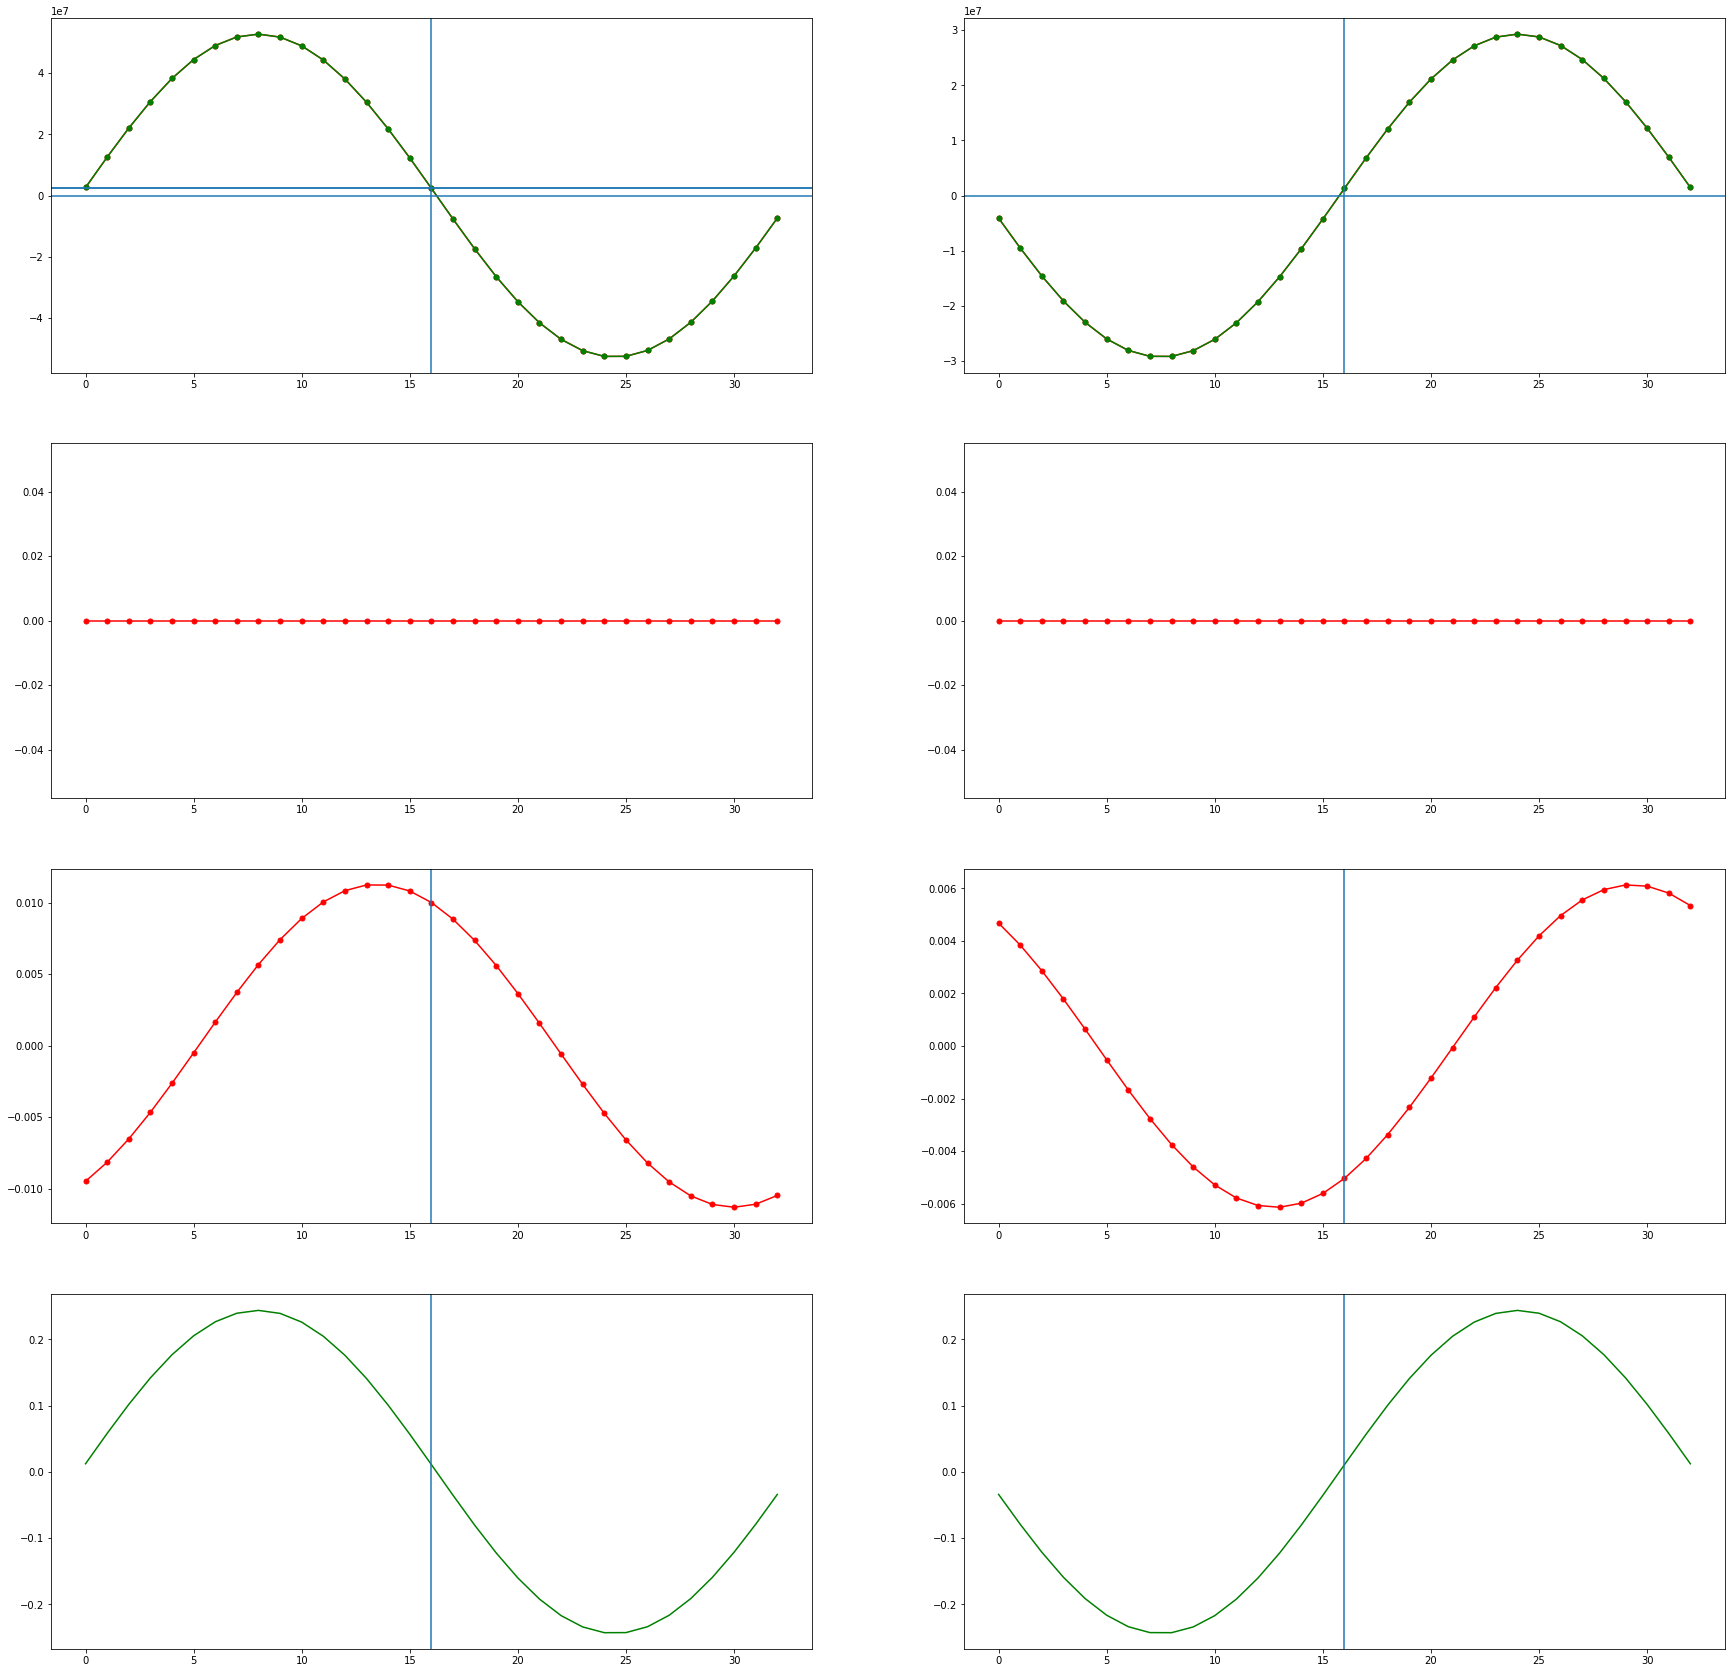

In [43]:
startTurn =1#int(nTurns/step-1)
startRF = 0*(nBunch-1)*fill_step
nRFsamp = 1

rng1 = NpRF*(h[0]*startTurn+startRF)+int(3*NpRF/8)*0
rng2 = NpRF*(h[0]*startTurn+startRF+nRFsamp)-int(3*NpRF/8)*0
step1 = 1
step2 = 1

if nRF>1:
    fig1,axes1 = plt.subplots(4,nRF)
    for i in range(nRF):
        axes1[0][i].plot(V[i][rng1:rng2:step1],'r.-',ms=10)
        axes1[0][i].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0][i].axhline(y=0)
        axes1[0][0].axhline(y=3.7e6/14*9)
        #axes1[0][1].axhline(y=3.7e6/14*6)
        #axes1[0][1].axhline(y=7.02e7)
        axes1[0][i].axvline(x=int(NpRF/2))
        axes1[1][i].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        if nBeam == 2 :
            axes1[1][i].plot(Ibi2[rng1:rng2:step1],'g.-',ms=10)
        axes1[2][i].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[2][i].axvline(x=int(NpRF/2))
        #axes1[3][i].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[3][i].plot((Iref[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].plot((Iref[i]-Ig[i])[rng1:rng2:step1],'g-',ms=10)
        axes1[3][i].axvline(x=int(NpRF/2))
        #axes1[0][i].set_ylim([-3e6,3e6])
else:
    fig1,axes1 = plt.subplots(4,1)
    for i in range(nRF):
        axes1[0].plot(V[i][rng1:rng2:step1],'rx-',ms=10)
        axes1[0].plot((Vref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[0].axhline(y=0)
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axhline(y=-V0Q[0])
        axes1[0].axvline(x=int(NpRF/2))
        #axes1[0].set_ylim([3.5e6,4e6])
        axes1[1].plot(Ibi[rng1:rng2:step1],'r.-',ms=10)
        axes1[1].axvline(x=int(NpRF/2))
        axes1[2].plot((V[i]-Vref[i])[rng1:rng2:step1],'r.-',ms=10)
        #axes1[2].set_ylim([-4e6,4e6])
        axes1[3].plot((Ig[i])[rng1:rng2:step1],'r.-',ms=10)
        axes1[3].plot((Iref[i])[rng1:rng2:step1],'g.-',ms=10)
        axes1[3].axhline(y=0)
        axes1[3].axvline(x=int(NpRF/2))
fig1.set_figheight(30)
fig1.set_figwidth(30)

fn_VI = os.path.join(cwd,'VI2.jpg')
plt.savefig(fn_VI,bbox_inches='tight')
plt.show()